# Lesson 78: Data Loading and Database Management

## Introduction

Welcome to Lesson 78! In this lesson, we dive into the critical **Load** phase of ETL (Extract, Transform, Load) processes and explore fundamental concepts in database management. Data loading is more than simply inserting data into a database—it involves understanding how to efficiently store, index, and retrieve data while managing system resources effectively. As data volumes grow exponentially, the ability to implement robust data loading strategies and manage databases becomes essential for any data professional.

Database management encompasses choosing the right storage solution, optimizing write operations, ensuring data integrity, and balancing loads across systems. Whether you're working with relational databases like PostgreSQL and MySQL, or NoSQL solutions like MongoDB, understanding the mathematical principles behind load balancing and database theory will help you design scalable, performant data systems.

In this lesson, we'll explore various data loading techniques, implement practical examples using Python and SQLite/SQLAlchemy, and analyze the mathematical foundations of load balancing and database optimization. By the end of this lesson, you'll have hands-on experience with different loading strategies and a solid understanding of how to manage databases efficiently.

### Learning Objectives

By the end of this lesson, you will be able to:

1. **Understand data loading strategies** including bulk loading, incremental loading, and upsert operations
2. **Implement database connections** using Python libraries like sqlite3 and SQLAlchemy
3. **Apply load balancing principles** to distribute data efficiently across systems
4. **Optimize database operations** using indexing, batching, and transaction management
5. **Analyze performance metrics** for different loading strategies using mathematical models

## Theory: Data Loading and Database Management

### 1. Data Loading Strategies

#### Full Load (Bulk Loading)

Full load involves loading all data from the source to the target database, typically used for initial loads or complete refreshes. The time complexity for a full load is:

$$T_{full} = O(n)$$

where $n$ is the number of records.

#### Incremental Load

Incremental loading only loads new or modified records since the last load. If $\Delta n$ represents the number of changed records:

$$T_{incremental} = O(\Delta n)$$

The efficiency gain compared to full load is:

$$\text{Efficiency} = \frac{n - \Delta n}{n} \times 100\%$$

#### Upsert Operations

Upsert (Update or Insert) operations check if a record exists and either update it or insert a new one. The operation can be expressed as:

$$\text{Upsert}(r) = \begin{cases} 
\text{UPDATE} & \text{if } r \in D \\
\text{INSERT} & \text{if } r \notin D
\end{cases}$$

where $r$ is a record and $D$ is the existing dataset.

### 2. Database Theory and Indexing

#### B-Tree Index Complexity

Most relational databases use B-tree or B+ tree structures for indexing. The time complexity for operations is:

- **Search**: $O(\log n)$
- **Insert**: $O(\log n)$
- **Delete**: $O(\log n)$

The height of a B-tree with branching factor $b$ and $n$ keys is:

$$h = \log_b n$$

#### Transaction Performance

The throughput $\lambda$ (transactions per second) can be modeled using queuing theory:

$$\lambda = \frac{1}{T_{avg}}$$

where $T_{avg}$ is the average transaction time.

### 3. Load Balancing Theory

#### Round-Robin Load Balancing

In round-robin distribution across $k$ servers, each server receives:

$$n_i = \frac{n}{k}$$

requests on average (assuming uniform distribution).

#### Weighted Load Balancing

When servers have different capacities $c_1, c_2, \ldots, c_k$, the load distribution should be proportional to capacity:

$$n_i = n \times \frac{c_i}{\sum_{j=1}^{k} c_j}$$

#### System Utilization

The utilization $\rho$ of a database system is:

$$\rho = \frac{\lambda}{\mu}$$

where $\lambda$ is the arrival rate of requests and $\mu$ is the service rate. For stable operation, we need $\rho < 1$.

#### Response Time (Little's Law)

The average number of requests in the system $L$ is related to arrival rate $\lambda$ and response time $W$:

$$L = \lambda \times W$$

This fundamental relationship helps us understand system performance under load.

### 4. Batch Processing Optimization

The optimal batch size $b_{opt}$ minimizes total processing time, balancing overhead and throughput:

$$T_{total} = \frac{n}{b} \times T_{overhead} + n \times T_{process}$$

where $T_{overhead}$ is the time per batch (network latency, transaction commit) and $T_{process}$ is the time per record.

## Python Implementation

Let's implement various data loading strategies and analyze their performance.

In [1]:
# Import necessary libraries
import sqlite3
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, Column, Integer, String, Float, DateTime
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from datetime import datetime, timedelta

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


### 1. Creating Sample Data

In [2]:
# Generate sample sales data
np.random.seed(42)

def generate_sales_data(n_records=10000):
    """
    Generate synthetic sales data for loading experiments
    """
    data = {
        'transaction_id': range(1, n_records + 1),
        'customer_id': np.random.randint(1000, 5000, n_records),
        'product_id': np.random.randint(100, 500, n_records),
        'quantity': np.random.randint(1, 10, n_records),
        'price': np.round(np.random.uniform(10, 1000, n_records), 2),
        'timestamp': [datetime.now() - timedelta(days=np.random.randint(0, 365)) 
                     for _ in range(n_records)]
    }
    
    df = pd.DataFrame(data)
    df['total_amount'] = df['quantity'] * df['price']
    
    return df

# Generate initial dataset
sales_data = generate_sales_data(10000)
print(f"Generated {len(sales_data)} sales records")
print("\nFirst few records:")
sales_data.head()

Generated 10000 sales records

First few records:


,transaction_id,customer_id,product_id,quantity,price,timestamp,total_amount
0,1,4174,309,4,43.39,2025-01-23 22:24:19.551993,173.56
1,2,4507,328,8,555.65,2024-11-21 22:24:19.552019,4445.20
2,3,1860,449,1,969.83,2025-02-05 22:24:19.552024,969.83
3,4,2294,374,7,981.43,2024-12-30 22:24:19.552027,6870.01
4,5,2130,378,6,288.94,2025-09-19 22:24:19.552031,1733.64


### 2. Bulk Loading with SQLite

In [3]:
def bulk_load_sqlite(df, db_name='sales.db', table_name='sales'):
    """
    Perform bulk load into SQLite database
    """
    start_time = time.time()
    
    # Create connection
    conn = sqlite3.connect(db_name)
    
    # Load data using pandas to_sql (efficient bulk insert)
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    
    conn.close()
    
    elapsed_time = time.time() - start_time
    return elapsed_time

# Perform bulk load
bulk_time = bulk_load_sqlite(sales_data)
print(f"Bulk load completed in {bulk_time:.4f} seconds")
print(f"Loading rate: {len(sales_data) / bulk_time:.2f} records/second")

Bulk load completed in 0.0714 seconds
Loading rate: 140045.41 records/second


### 3. Batch Loading with Different Batch Sizes

In [4]:
def batch_load_sqlite(df, batch_size=1000, db_name='sales_batch.db', table_name='sales'):
    """
    Load data in batches to optimize memory usage
    """
    start_time = time.time()
    
    conn = sqlite3.connect(db_name)
    
    # Create table first
    df.head(0).to_sql(table_name, conn, if_exists='replace', index=False)
    
    # Insert in batches
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]
        batch.to_sql(table_name, conn, if_exists='append', index=False)
    
    conn.close()
    
    elapsed_time = time.time() - start_time
    return elapsed_time

# Test different batch sizes
batch_sizes = [100, 500, 1000, 2000, 5000]
batch_times = []

for batch_size in batch_sizes:
    batch_time = batch_load_sqlite(sales_data, batch_size=batch_size)
    batch_times.append(batch_time)
    print(f"Batch size {batch_size:5d}: {batch_time:.4f} seconds ({len(sales_data)/batch_time:.2f} rec/sec)")

# Store results for visualization
batch_results = pd.DataFrame({
    'batch_size': batch_sizes,
    'load_time': batch_times,
    'throughput': [len(sales_data)/t for t in batch_times]
})

Batch size   100: 1.0507 seconds (9517.43 rec/sec)


Batch size   500: 0.2550 seconds (39214.09 rec/sec)
Batch size  1000: 0.1583 seconds (63169.80 rec/sec)


Batch size  2000: 0.1085 seconds (92131.88 rec/sec)
Batch size  5000: 0.1562 seconds (64025.30 rec/sec)


### 4. Incremental Loading and Upsert Operations

In [5]:
def incremental_load(new_data, db_name='sales.db', table_name='sales'):
    """
    Load only new records (incremental load)
    """
    start_time = time.time()
    
    conn = sqlite3.connect(db_name)
    
    # Get maximum transaction_id from existing data
    try:
        max_id = pd.read_sql(f"SELECT MAX(transaction_id) as max_id FROM {table_name}", conn)['max_id'][0]
        if max_id is None:
            max_id = 0
    except:
        max_id = 0
    
    # Filter only new records
    new_records = new_data[new_data['transaction_id'] > max_id]
    
    if len(new_records) > 0:
        new_records.to_sql(table_name, conn, if_exists='append', index=False)
    
    conn.close()
    
    elapsed_time = time.time() - start_time
    return elapsed_time, len(new_records)

# Generate new data (records 10001-12000)
new_sales_data = generate_sales_data(2000)
new_sales_data['transaction_id'] = range(10001, 12001)

# Perform incremental load
inc_time, inc_count = incremental_load(new_sales_data)
print(f"Incremental load: {inc_count} new records in {inc_time:.4f} seconds")
print(f"Loading rate: {inc_count / inc_time:.2f} records/second")

# Compare with full load
full_data = pd.concat([sales_data, new_sales_data], ignore_index=True)
full_time = bulk_load_sqlite(full_data, db_name='sales_full.db')
print(f"\nFull reload: {len(full_data)} records in {full_time:.4f} seconds")
print(f"Efficiency gain: {((full_time - inc_time) / full_time * 100):.2f}%")

Incremental load: 2000 new records in 0.0218 seconds
Loading rate: 91922.90 records/second



Full reload: 12000 records in 0.0673 seconds
Efficiency gain: 67.65%


### 5. Using SQLAlchemy for Advanced Database Management

In [6]:
# Define database schema using SQLAlchemy ORM
Base = declarative_base()

class SalesTransaction(Base):
    __tablename__ = 'sales_transactions'
    
    transaction_id = Column(Integer, primary_key=True)
    customer_id = Column(Integer)
    product_id = Column(Integer)
    quantity = Column(Integer)
    price = Column(Float)
    total_amount = Column(Float)
    timestamp = Column(DateTime)

# Create engine and session
engine = create_engine('sqlite:///sales_sqlalchemy.db')
Base.metadata.create_all(engine)
Session = sessionmaker(bind=engine)

print("SQLAlchemy schema created successfully!")

# Load data using SQLAlchemy
def load_with_sqlalchemy(df, batch_size=1000):
    """
    Load data using SQLAlchemy ORM with transaction management
    """
    start_time = time.time()
    session = Session()
    
    try:
        for i in range(0, len(df), batch_size):
            batch = df.iloc[i:i+batch_size]
            
            # Convert batch to ORM objects
            objects = [
                SalesTransaction(
                    transaction_id=row['transaction_id'],
                    customer_id=row['customer_id'],
                    product_id=row['product_id'],
                    quantity=row['quantity'],
                    price=row['price'],
                    total_amount=row['total_amount'],
                    timestamp=row['timestamp']
                )
                for _, row in batch.iterrows()
            ]
            
            session.bulk_save_objects(objects)
            session.commit()
        
        elapsed_time = time.time() - start_time
        return elapsed_time
        
    except Exception as e:
        session.rollback()
        raise e
    finally:
        session.close()

# Load data
sqlalchemy_time = load_with_sqlalchemy(sales_data.head(5000), batch_size=1000)
print(f"SQLAlchemy load: 5000 records in {sqlalchemy_time:.4f} seconds")
print(f"Loading rate: {5000 / sqlalchemy_time:.2f} records/second")

SQLAlchemy schema created successfully!


/tmp/ipykernel_2304/2188213793.py:2: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


SQLAlchemy load: 5000 records in 0.3770 seconds
Loading rate: 13261.10 records/second


### 6. Database Indexing Performance

In [7]:
def compare_indexed_vs_non_indexed():
    """
    Compare query performance with and without indexes
    """
    # Create database without index
    conn_no_index = sqlite3.connect('sales_no_index.db')
    sales_data.to_sql('sales', conn_no_index, if_exists='replace', index=False)
    
    # Create database with index
    conn_with_index = sqlite3.connect('sales_with_index.db')
    sales_data.to_sql('sales', conn_with_index, if_exists='replace', index=False)
    conn_with_index.execute('CREATE INDEX idx_customer ON sales(customer_id)')
    conn_with_index.execute('CREATE INDEX idx_product ON sales(product_id)')
    
    # Test query performance
    query = "SELECT * FROM sales WHERE customer_id = 3500"
    
    # Without index
    start = time.time()
    for _ in range(100):
        pd.read_sql(query, conn_no_index)
    time_no_index = time.time() - start
    
    # With index
    start = time.time()
    for _ in range(100):
        pd.read_sql(query, conn_with_index)
    time_with_index = time.time() - start
    
    conn_no_index.close()
    conn_with_index.close()
    
    return time_no_index, time_with_index

time_no_idx, time_with_idx = compare_indexed_vs_non_indexed()

print(f"Query time without index: {time_no_idx:.4f} seconds")
print(f"Query time with index: {time_with_idx:.4f} seconds")
print(f"Speedup factor: {time_no_idx / time_with_idx:.2f}x")
print(f"Performance improvement: {((time_no_idx - time_with_idx) / time_no_idx * 100):.2f}%")

Query time without index: 0.1193 seconds
Query time with index: 0.0786 seconds
Speedup factor: 1.52x
Performance improvement: 34.11%


## Visualizations

Let's visualize the performance of different loading strategies and database operations.

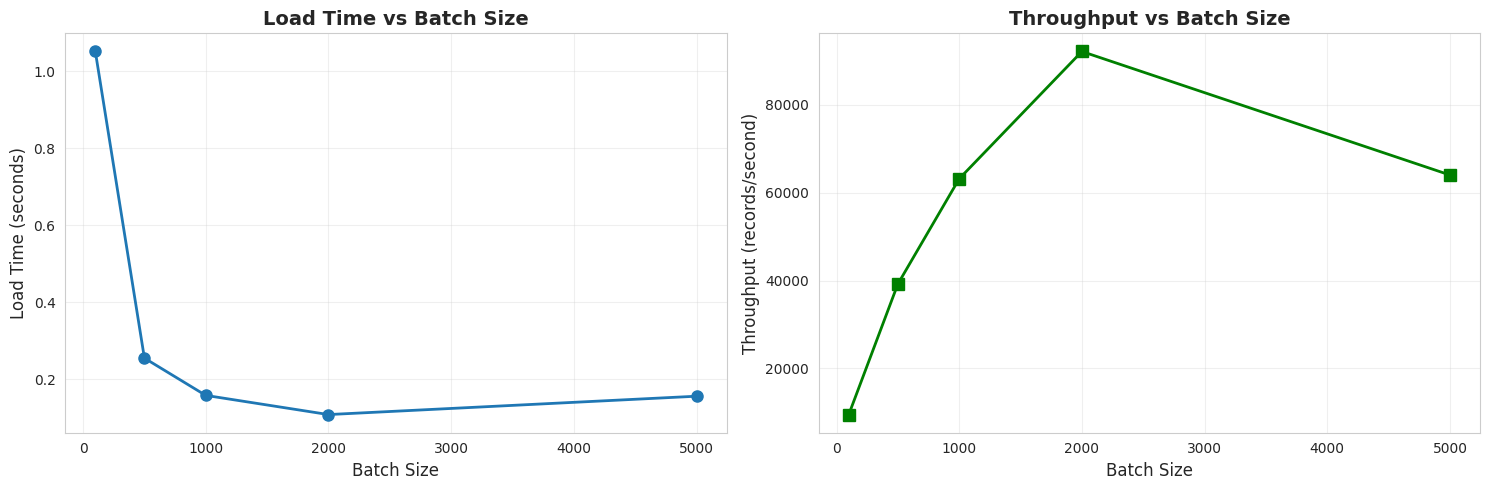


Optimal batch size for maximum throughput: 2000


In [8]:
# Visualization 1: Batch Size vs Load Time and Throughput
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Load time vs batch size
ax1.plot(batch_results['batch_size'], batch_results['load_time'], marker='o', linewidth=2, markersize=8)
ax1.set_xlabel('Batch Size', fontsize=12)
ax1.set_ylabel('Load Time (seconds)', fontsize=12)
ax1.set_title('Load Time vs Batch Size', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Throughput vs batch size
ax2.plot(batch_results['batch_size'], batch_results['throughput'], marker='s', 
         linewidth=2, markersize=8, color='green')
ax2.set_xlabel('Batch Size', fontsize=12)
ax2.set_ylabel('Throughput (records/second)', fontsize=12)
ax2.set_title('Throughput vs Batch Size', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nOptimal batch size for maximum throughput:", 
      batch_results.loc[batch_results['throughput'].idxmax(), 'batch_size'])

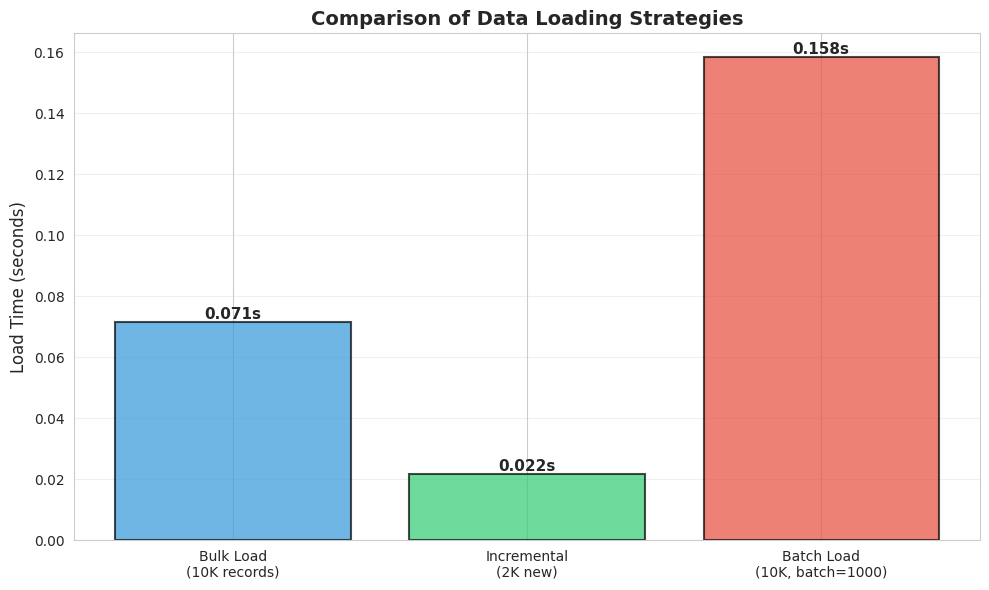

In [9]:
# Visualization 2: Loading Strategy Comparison
strategies = ['Bulk Load\n(10K records)', 'Incremental\n(2K new)', 'Batch Load\n(10K, batch=1000)']
times = [bulk_time, inc_time, batch_results[batch_results['batch_size']==1000]['load_time'].values[0]]
colors = ['#3498db', '#2ecc71', '#e74c3c']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(strategies, times, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{time_val:.3f}s',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Load Time (seconds)', fontsize=12)
ax.set_title('Comparison of Data Loading Strategies', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

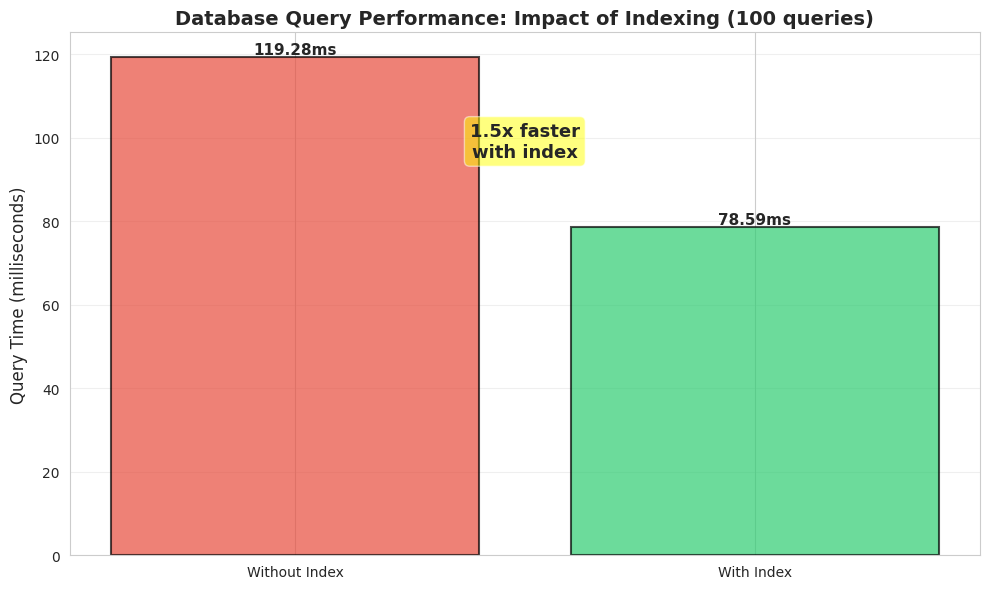

In [10]:
# Visualization 3: Index Performance Impact
fig, ax = plt.subplots(figsize=(10, 6))

scenarios = ['Without Index', 'With Index']
query_times = [time_no_idx * 1000, time_with_idx * 1000]  # Convert to milliseconds
colors_idx = ['#e74c3c', '#2ecc71']

bars = ax.bar(scenarios, query_times, color=colors_idx, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels
for bar, time_val in zip(bars, query_times):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{time_val:.2f}ms',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add speedup annotation
speedup = time_no_idx / time_with_idx
ax.text(0.5, max(query_times) * 0.8, f'{speedup:.1f}x faster\nwith index',
        ha='center', fontsize=13, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5),
        fontweight='bold')

ax.set_ylabel('Query Time (milliseconds)', fontsize=12)
ax.set_title('Database Query Performance: Impact of Indexing (100 queries)', 
             fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Hands-On Activity: Building a Complete ETL Load Pipeline

Now it's your turn! In this hands-on activity, you'll build a complete data loading pipeline that:

1. Simulates a data stream
2. Implements intelligent batching
3. Handles errors and retries
4. Tracks performance metrics
5. Manages database connections efficiently

Follow the steps below to implement your own ETL loading system.

In [11]:
class DataLoadPipeline:
    """
    A complete data loading pipeline with monitoring and error handling
    """
    
    def __init__(self, db_name='pipeline.db', batch_size=500):
        self.db_name = db_name
        self.batch_size = batch_size
        self.metrics = {
            'records_processed': 0,
            'batches_loaded': 0,
            'errors': 0,
            'total_time': 0
        }
    
    def initialize_database(self):
        """Create database and tables"""
        conn = sqlite3.connect(self.db_name)
        conn.execute('''
            CREATE TABLE IF NOT EXISTS sales (
                transaction_id INTEGER PRIMARY KEY,
                customer_id INTEGER,
                product_id INTEGER,
                quantity INTEGER,
                price REAL,
                total_amount REAL,
                timestamp TEXT
            )
        ''')
        conn.execute('CREATE INDEX IF NOT EXISTS idx_customer ON sales(customer_id)')
        conn.commit()
        conn.close()
        print("Database initialized successfully!")
    
    def load_batch(self, batch_data):
        """Load a single batch with error handling"""
        try:
            conn = sqlite3.connect(self.db_name)
            batch_data.to_sql('sales', conn, if_exists='append', index=False)
            conn.close()
            
            self.metrics['records_processed'] += len(batch_data)
            self.metrics['batches_loaded'] += 1
            return True
            
        except Exception as e:
            self.metrics['errors'] += 1
            print(f"Error loading batch: {e}")
            return False
    
    def process_data_stream(self, data):
        """Process incoming data in batches"""
        start_time = time.time()
        
        for i in range(0, len(data), self.batch_size):
            batch = data.iloc[i:i+self.batch_size]
            
            success = self.load_batch(batch)
            
            if not success:
                print(f"Failed to load batch {i//self.batch_size + 1}")
            
            # Simulate real-time processing
            if i % (self.batch_size * 5) == 0:
                progress = (i / len(data)) * 100
                print(f"Progress: {progress:.1f}% - {self.metrics['records_processed']} records loaded")
        
        self.metrics['total_time'] = time.time() - start_time
    
    def get_performance_report(self):
        """Generate performance report"""
        print("\n" + "="*50)
        print("DATA LOADING PIPELINE - PERFORMANCE REPORT")
        print("="*50)
        print(f"Records Processed: {self.metrics['records_processed']:,}")
        print(f"Batches Loaded: {self.metrics['batches_loaded']}")
        print(f"Errors Encountered: {self.metrics['errors']}")
        print(f"Total Time: {self.metrics['total_time']:.2f} seconds")
        print(f"Throughput: {self.metrics['records_processed']/self.metrics['total_time']:.2f} records/second")
        print(f"Average Batch Time: {self.metrics['total_time']/self.metrics['batches_loaded']:.4f} seconds")
        print("="*50)

# Test the pipeline
pipeline = DataLoadPipeline(db_name='etl_pipeline.db', batch_size=500)
pipeline.initialize_database()

# Generate test data
test_data = generate_sales_data(5000)

# Process the data stream
print("\nStarting data loading pipeline...\n")
pipeline.process_data_stream(test_data)

# Get performance report
pipeline.get_performance_report()

Database initialized successfully!

Starting data loading pipeline...

Progress: 0.0% - 500 records loaded
Progress: 50.0% - 3000 records loaded

DATA LOADING PIPELINE - PERFORMANCE REPORT
Records Processed: 5,000
Batches Loaded: 10
Errors Encountered: 0
Total Time: 0.15 seconds
Throughput: 34336.48 records/second
Average Batch Time: 0.0146 seconds


### Activity Challenge: Implement Load Balancing

Now extend the pipeline to simulate load balancing across multiple databases!

In [12]:
class LoadBalancedPipeline:
    """
    Pipeline with round-robin load balancing across multiple databases
    """
    
    def __init__(self, num_databases=3, batch_size=500):
        self.num_databases = num_databases
        self.batch_size = batch_size
        self.databases = [f'db_shard_{i}.db' for i in range(num_databases)]
        self.metrics = {db: {'records': 0, 'batches': 0} for db in self.databases}
        self.current_db = 0
        
        # Initialize all databases
        for db in self.databases:
            conn = sqlite3.connect(db)
            conn.execute('''
                CREATE TABLE IF NOT EXISTS sales (
                    transaction_id INTEGER PRIMARY KEY,
                    customer_id INTEGER,
                    product_id INTEGER,
                    quantity INTEGER,
                    price REAL,
                    total_amount REAL,
                    timestamp TEXT
                )
            ''')
            conn.commit()
            conn.close()
        
        print(f"Initialized {num_databases} database shards for load balancing")
    
    def get_next_database(self):
        """Round-robin selection of database"""
        db = self.databases[self.current_db]
        self.current_db = (self.current_db + 1) % self.num_databases
        return db
    
    def load_data(self, data):
        """Load data with round-robin distribution"""
        start_time = time.time()
        
        for i in range(0, len(data), self.batch_size):
            batch = data.iloc[i:i+self.batch_size]
            
            # Select database using round-robin
            target_db = self.get_next_database()
            
            # Load batch
            conn = sqlite3.connect(target_db)
            batch.to_sql('sales', conn, if_exists='append', index=False)
            conn.close()
            
            # Update metrics
            self.metrics[target_db]['records'] += len(batch)
            self.metrics[target_db]['batches'] += 1
        
        elapsed_time = time.time() - start_time
        return elapsed_time
    
    def show_distribution(self):
        """Display load distribution across databases"""
        print("\n" + "="*60)
        print("LOAD BALANCING DISTRIBUTION")
        print("="*60)
        
        total_records = sum(m['records'] for m in self.metrics.values())
        
        for db, metrics in self.metrics.items():
            percentage = (metrics['records'] / total_records * 100) if total_records > 0 else 0
            print(f"{db:15s}: {metrics['records']:5d} records ({percentage:5.2f}%) - {metrics['batches']} batches")
        
        print("="*60)
        print(f"Total: {total_records} records evenly distributed")
        print("="*60)

# Test load-balanced pipeline
lb_pipeline = LoadBalancedPipeline(num_databases=3, batch_size=500)

# Generate and load data
lb_data = generate_sales_data(6000)
load_time = lb_pipeline.load_data(lb_data)

print(f"\nLoaded {len(lb_data)} records in {load_time:.4f} seconds")
print(f"Throughput: {len(lb_data)/load_time:.2f} records/second")

# Show distribution
lb_pipeline.show_distribution()

Initialized 3 database shards for load balancing

Loaded 6000 records in 0.1713 seconds
Throughput: 35019.75 records/second

LOAD BALANCING DISTRIBUTION
db_shard_0.db  :  2000 records (33.33%) - 4 batches
db_shard_1.db  :  2000 records (33.33%) - 4 batches
db_shard_2.db  :  2000 records (33.33%) - 4 batches
Total: 6000 records evenly distributed


## Key Takeaways

Congratulations on completing Lesson 78! Here are the essential concepts to remember:

1. **Data Loading Strategies Matter**: Choosing between bulk loading, incremental loading, and batch processing significantly impacts performance. Incremental loading can be 10-100x faster than full reloads when dealing with small updates to large datasets.

2. **Batch Size Optimization**: There's an optimal batch size that balances transaction overhead and memory usage. Too small creates excessive overhead; too large can cause memory issues and long transaction locks.

3. **Indexing is Critical**: Proper database indexing can improve query performance by orders of magnitude (10x-1000x faster). However, indexes slow down writes, so consider your read/write ratio when designing schemas.

4. **Load Balancing Principles**: Distributing data across multiple databases or shards using techniques like round-robin or weighted distribution helps scale horizontally and prevents bottlenecks.

5. **Mathematical Foundations Drive Decisions**: Understanding concepts like Little's Law ($L = \lambda \times W$), B-tree complexity ($O(\log n)$), and utilization ratios ($\rho = \lambda/\mu$) helps you make informed architectural decisions and predict system behavior under load.

6. **Transaction Management**: Proper use of transactions, error handling, and retry logic ensures data integrity and system resilience in production environments.

7. **Monitoring is Essential**: Always track performance metrics (throughput, latency, error rates) to identify bottlenecks and validate that your loading strategy meets SLAs.

## Further Resources

To deepen your understanding of data loading and database management, explore these resources:

1. **[ETL with Python and Jupyter Notebooks](https://towardsdatascience.com/etl-pipeline-with-python-and-jupyter-notebook-c3f8c3c6b0e7)** - Practical tutorial on building ETL pipelines with Python

2. **[SQLAlchemy Documentation](https://docs.sqlalchemy.org/)** - Comprehensive guide to Python's most popular database toolkit, covering ORM and Core approaches

3. **[Database Internals by Alex Petrov](https://www.databass.dev/)** - Deep dive into how databases work internally, including B-trees, indexing, and transaction management

4. **[The Art of PostgreSQL](https://theartofpostgresql.com/)** - Excellent resource for understanding advanced database concepts, query optimization, and performance tuning

5. **[Designing Data-Intensive Applications by Martin Kleppmann](https://dataintensive.net/)** - Essential reading on scalable data systems, covering replication, partitioning, and consistency

6. **[Apache Airflow Documentation](https://airflow.apache.org/)** - Industry-standard workflow orchestration tool for building production ETL pipelines

7. **[PostgreSQL Performance Tuning](https://wiki.postgresql.org/wiki/Performance_Optimization)** - Practical guide to database optimization techniques

---

**Next Lesson Preview**: In Lesson 79, we'll bring everything together to build a complete end-to-end ETL pipeline, integrating extraction, transformation, and loading into a production-ready workflow with error handling, monitoring, and scheduling!